# Data Science: Individual Planning Report
This R notebook will perform the individual planning stage of the data science project. The main pursuits of this report include understanding the data, formulating a specific inquiry derived from one of the three broad questions, creating several visualizations to foster greater comprehension of the data and foreseeable roadblocks, and selecting an appropriate method to address my question of interest.

In [1]:
### Run this cell before continuing to load in the necessary R packages.
library(tidyverse)
library(repr)
library(rvest)
library(RColorBrewer)
library(scales)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
# Read in datasets directly from their raw URLs obtained from the GitHub repository

# Read in player.csv file
url_players <- "https://raw.githubusercontent.com/Adrian12-max/Data-Science-Project-Individual-Planning-Stage/refs/heads/main/players.csv"
players <- read_csv(url_players)

# Read in sessions.csv file
url_sessions <- "https://raw.githubusercontent.com/Adrian12-max/Data-Science-Project-Individual-Planning-Stage/refs/heads/main/sessions.csv"
sessions <- read_csv(url_sessions)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 1. Data Description

**players.csv:** provides a list including demographic information and self-reported play statistics for each player. Each row corresponds to a unique player. This tibble contains 196 observations/rows and 7 variables/columns. The variables include:

- `experience` (character): Self-reported playing experience: *Newbie, Amateur, Regular, Veteran, or Pro*
- `subscribe` (logical): Whether the player is subscribed to the game-related newspaper (evaluates to either TRUE or FALSE)
- `hashedEmail` (character): A unique hashed identifier used to link sessions to players
- `played_hours` (double): Total number of hours the player has spent on the server
- `name` (character): The player's self-reported name
- `gender` (character): The player's self-reported gender 
- `Age` (double): The age of the player in years
  
**sessions.csv:** provides a list of all individual play sessions by each player, including data about the session. Each row records one play session for a player. This tibble contains 1535 observations/rows and 5 variables/columns. The variables include:

- `hashedEmail` (character): A unique hashed identifier used to link sessions to players
- `start_time` (character): The local date-time (in year-month-day hour:minute format) representing when the session began
- `end_time` (character): The local data-time (in year-month-day hour:minute format) representing when the session ended
- `original_start_time` (double): Numeric timestamp (in milliseconds since 1970-01-01 00:00:00 UTC) indicating when the session began
- `original_end_time` (double): Numeric timestamp (in milliseconds since 1970-01-01 00:00:00 UTC) indicating when the session ended

**Summary Statistics**

| Variable       | Mean  | Min  | Max    | Sum     |
| -------------- | ----- | ---- | ----   | ------  |
| `Age`          | 21.14 | 9.00 | 58.00  | 4101.00 |
| `played_hours` | 5.90  | 0.00 | 223.10 | 1145.80 | 

**Visible Issues in Data**

1. The `Age` variable in the `players.csv` dataset contains two `NA` values that should be addressed, either through mean imputation or by removing the rows with missing values altogether.
2. Two observations within the `sessions.csv` dataset contain `NA` values for the `end_time` and `original_end_time` variables. 
3. Currently, the `subscribe` variable is stored as a logical data type. To ensure that KNN classification functions properly, this variable should be converted to a factor so that "TRUE" and "FALSE" are treated as categorical classes.

**Potential Issues Not Directly Seen**

1. Since `Age` and `played_hours` are measured on varying scales, they must first be standardized (centered and scaled) during data preprocessing to ensure that they contribute equally to the model's prediction.
2. Class imbalance may be present within the `subscribe` variable of the `players.csv` dataset, meaning that one label occurs much more frequently than the other. This imbalance can cause our KNN classifier to become biased toward the majority class (even if the "pattern" of the data suggests otherwise), therefore reducing its predictive accuracy for the minority label.

## 2. Questions

**Selected Broad Question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific Inquiry:** Can `Age` and `played_hours` predict whether a player subscribes to the game-related newsletter (`subscribe`) in the `players.csv` dataset?

**How will the data help address this question?**

The `players.csv` dataset contains all three of the necessary variables:
- `Age` (double) 
- `played_hours` (double) 
- `subscribe` (logical)

This inquiry uses `subscribe` (logical) as the response variable and `Age` (numeric) and `played_hours` (numeric) as the predictor/explanatory variables. These variables are sufficient to apply the K-nearest neighbours (KNN) binary classification model to determine whether certain patterns of playtime and age are associated with a lower or higher likelihood of subscribing to the newsletter. Because KNN classification predicts labels based on how similar data points are to other labelled observations, it works particularly well with numerical explanatory variables, where the Euclidean distance (similarity) between points can be calculated mathematically.

**Data Wrangling**

To resolve the missing values within the `players.csv` dataset, the rows containing `NA` values may simply be removed using the `drop_na()` function. Because only two observations are affected, it is appropriate to use such a method over mean imputation. However, if many rows contained missing entries, it would be unreasonable to throw away large portions of our data, in which case we would fill in synthetic values based on other observations in the dataset. Since we will be working with `subscribe` as a categorical variable, we should convert it to a factor using the `as_factor` function. To improve the readability of our analysis, we will use the `fct_recode` method to replace the names of factor values with other names. For this analysis, we will rename "TRUE" to "Subscribed" and "FALSE" to "Unsubscribed". This is the **minimum** wrangling that should be done. Subsequent steps include using the `initial_split` function to split the data into a training and testing set, using the `vfold_cv` function to split the training data for cross-validation, and standardizing the explanatory variables during data preprocessing.

## 3. Exploratory Data Analysis and Visualization

In [3]:
# Read in datasets directly from their raw URLs obtained from the GitHub repository

# Read in player.csv file
url_players <- "https://raw.githubusercontent.com/Adrian12-max/Data-Science-Project-Individual-Planning-Stage/refs/heads/main/players.csv"
players <- read_csv(url_players)
players

# Read in sessions.csv file
url_sessions <- "https://raw.githubusercontent.com/Adrian12-max/Data-Science-Project-Individual-Planning-Stage/refs/heads/main/sessions.csv"
sessions <- read_csv(url_sessions) 
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15/04/2024 07:12,15/04/2024 07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,21/09/2024 02:13,21/09/2024 02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,21/06/2024 02:31,21/06/2024 02:49,1.71894e+12,1.71894e+12


In [4]:
# Minimum necessary wrangling to turn `players.csv` dataset into tidy format

# Remove rows with any missing values
players <- players |>
    drop_na() |>
    # Convert `subscribe` (categorical variable) from logical to factor data type
    mutate(subscribe = as_factor(subscribe)) |>
    # Replace the name of factor values ("TRUE" and "FALSE") with more appropriate ones
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Unsubscribed" = "FALSE"))
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Unsubscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,Subscribed,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,Subscribed,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,Subscribed,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,Subscribed,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,Unsubscribed,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,Subscribed,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


In [5]:
# Mean value computations for each quantitative variable in the players.csv data set
players_summary <- players |>
    summarize(mean_played_hours = mean(played_hours),
        mean_age = mean(Age))


| Variable       | Mean  |
| -------------- | ----- | 
| `Age`          | 21.14 | 
| `played_hours` | 5.90  |

### Exploratory Visualizations

#### 1. Histogram of player ages by subscription status:

The histogram below reveals that the majority of players are between 15 and 25 years old. Subscribers are concentrated within this range, beyond which they begin to level off, and proportions of subscribed and unsubscribed players appear to be approximately equal. Relating these findings to my specific inquiry, they suggest that when predicting the subscription status of an older player, they are more likely to be unsubscribed than a younger one.

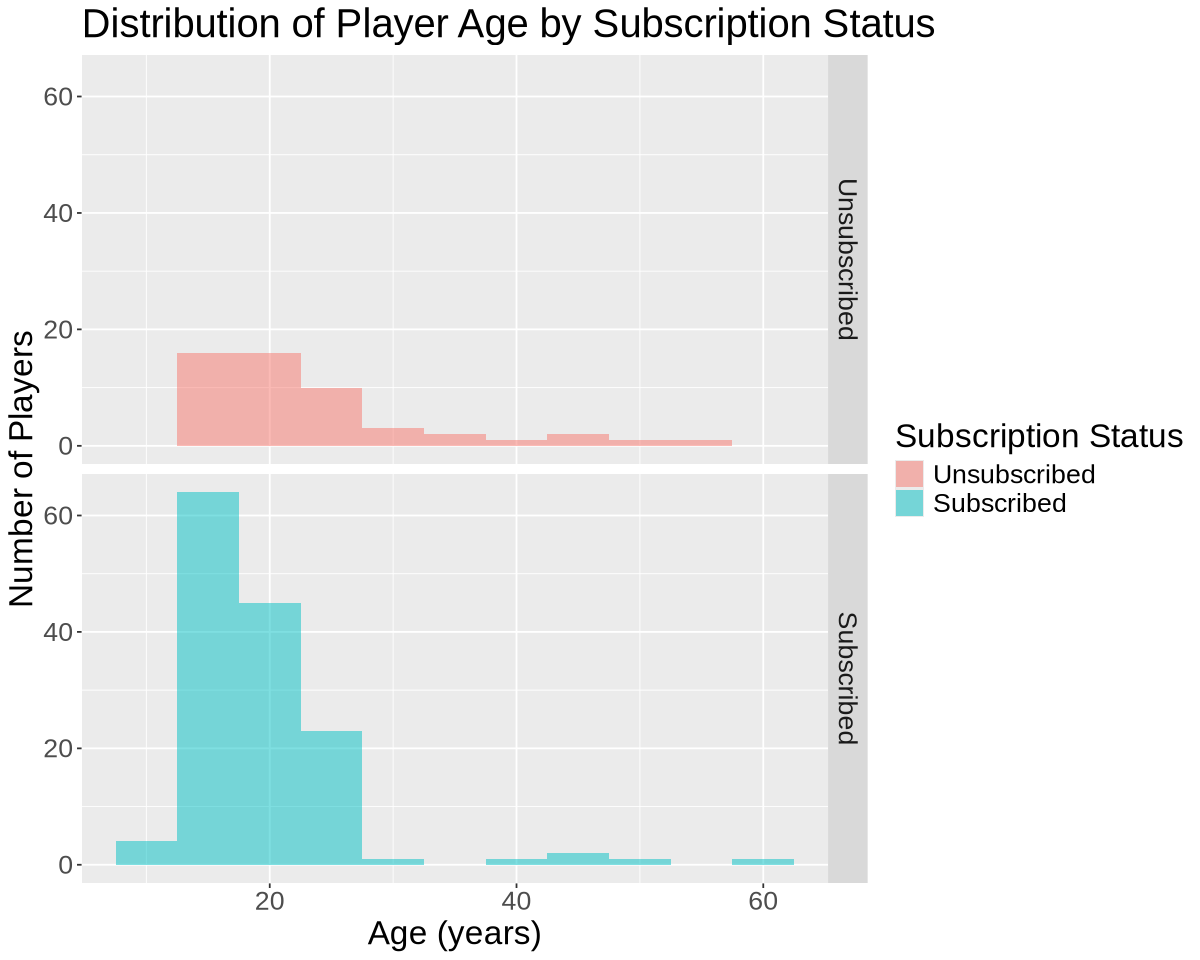

In [10]:
# Set the plot size
options(repr.plot.width = 10, repr.plot.height = 8)

# Create a histogram of player ages by subscription status
age_histogram <- players |>
ggplot(aes(x = Age, fill = subscribe)) +  # map Age to the x-axis and subscribe to fill
    geom_histogram(position = "identity", binwidth = 5, alpha = 0.5) +  # use 5-year bins
    labs(title = "Distribution of Player Age by Subscription Status",  # main title for plot
         x = "Age (years)",  # x-axis title
         y = "Number of Players", # y-axis title
         fill = "Subscription Status") + # fill legend title
         facet_grid(rows = vars(subscribe)) + # split the plot horizontally into rows by the `subscribe variable`
    theme(text = element_text(size = 20)) # change text size
age_histogram

#### 2. Scatterplot of total play hours vs. age:

The scatterplot below shows that the majority of players who have spent more than 1 total hour playing are heavily concentrated within the previously noted age range. Additionally, all players, regardless of age, who have accumulated more than 10 total hours played are subscribed. Relating these findings to my specific inquiry, they suggest that when predicting the subscription status of a frequent player, they are more likely to be subscribed than an infrequent player who has logged less than 1 hour played.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


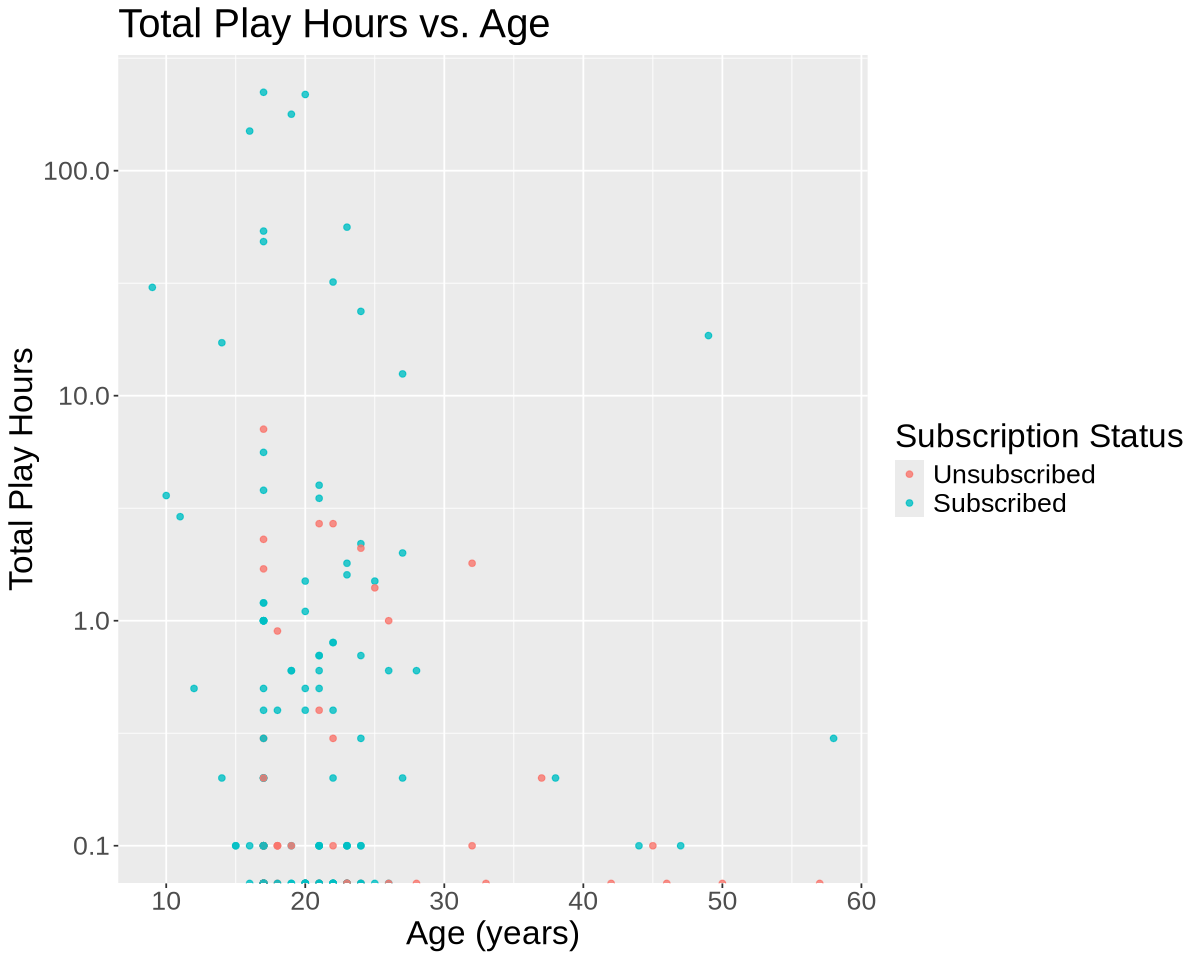

In [12]:
# Set the plot size
options(repr.plot.width = 10, repr.plot.height = 8)

# Scatter plot of total play hours vs. age
hours_vs_age_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, colour = subscribe)) +
    geom_point(alpha = 0.8) +
    labs(title = "Total Play Hours vs. Age", 
         x = "Age (years)",
         y = "Total Play Hours",
         colour = "Subscription Status") +
    scale_y_log10() +  # Log‑scale the y‑axis
    theme(text = element_text(size = 20))
hours_vs_age_plot

## 4. Methods and Plans

To answer the specific inquiry question, we will fit a KNN binary classification model with `subscribe` as the response variable and `Age` and `played_hours` as the predictor/explanatory variables. 

### 1. Why is this method appropriate

The K-nearest neighbours classification algorithm is an appropriate method for this analysis since our question involves predicting a categorical (class) label ("Subscribed" or "Unsubscribed") using numerical explanatory variables (`Age` and `played_hours`).

### 2. Which assumptions are required, if any, to apply the method selected?

When working with KNN classification algorithms, minimal assumptions are required about the distribution of data. This versatility stems from the use of nearest neighbours to predict values. As a result, one of the key strengths of the algorithm is its ability to work effectively with non-linear relationships, which are common between variables in most real-world datasets.

### 3. What are the potential limitations or weaknesses of the method selected?

As with any prediction algorithm, KNN classification has its weaknesses and limitations. These include becoming computationally expensive as the training data gets larger, struggling when given a large number of predictors, and underperforming when classes are imbalanced. This is because when the dimensionality (the number of predictors) increases, the distance between points becomes less meaningful; thus, the model performs worse. As mentioned previously, KNN classification is sensitive to predictor variable scaling; hence, the predictors are normally standardized during preprocessing to achieve comparable scales. A limitation, if not resolved through techniques such as oversampling the rare class, is class imbalance, where one label is much more common than the other. Lastly, KNN may not be suitable for noisy data, as the K-nearest neighbours may not be representative of the true class label. 

### 4. How are you going to compare and select the model?

To select the best-performing KNN classification model, the optimal number of neighbors (K) that yields the highest accuracy will be identified through cross-validation tuning. Since cross-validation helps us evaluate the accuracy of our classifier, we can use it to calculate an accuracy for every value of K within a reasonable range. The procedure for tuning models involves specifying each parameter in the model as `tune()`, using the `tune-grid` function to fit the model for each value in a range of parameter values, and then determining the `K` that results in the highest mean accuracy. This `K` shall be used unless changing the value to a nearby one significantly decreases the accuracy, or if `K` creates a prohibitively expensive computational cost (value of `K` is too large).

### 5. How are you going to process the data to apply the model?

To process the data, it will be split into the training and testing sets, respectively. To obtain an appropriate tradeoff between training accuracy and performance evaluation accuracy, the data will be split into 70% for training and 30% for testing using the `initial_split` function from the `tidymodels` library near the beginning of the analysis. By splitting the data near the start, we can train our KNN classifier with only the training set and use it to predict the class labels in the test set. Furthermore, a 5- or 10-fold cross-validation will be applied to the overall training data to obtain the optimal *K*. This process involves iteratively using one chunk as the validation set and the remaining *C*-1 chunks as the training set.



## 5. GitHub Repository